# ULMFiT Sentiment

Challenge: Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment

In [1]:
# import packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 150)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re
from functools import partial
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Load, check, explore data

In [2]:
# read raw data
data = pd.read_csv("Tweets.csv")

In [3]:
# exam the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

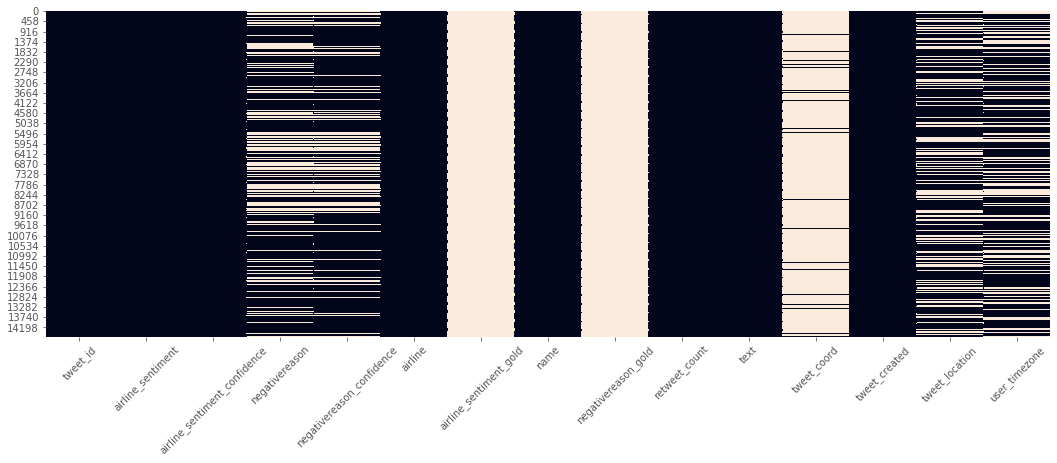

In [4]:
# missing value plot
plt.figure(figsize=(18,6))
ax = sns.heatmap(data.isnull(), cbar=False, xticklabels=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

We can see from the data:
- for information including "gold", we have lots of missing data
- features like negative reason, tweet location has some missing data
- key information including text, sentiment, airline do not have missing data

No imputation needed at this time since the missing info has little to do with our purpose

In [5]:
# get a df of our x and y for model
df = data[['text','airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [6]:
df.loc[2,'text']

"@VirginAmerica I didn't today... Must mean I need to take another trip!"

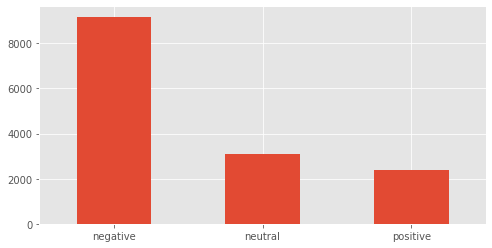

In [7]:
# plot the distribution of sentiments
plt.figure(figsize=(8,4))
data['airline_sentiment'].value_counts().plot(kind='bar', rot=0)
plt.show()

In [8]:
sentiment_value_count = data['airline_sentiment'].value_counts()
for cate in sentiment_value_count.index:
    print(f"Percentage of {cate}: {sentiment_value_count[cate] / sentiment_value_count.sum():.3f}")

Percentage of negative: 0.627
Percentage of neutral: 0.212
Percentage of positive: 0.161


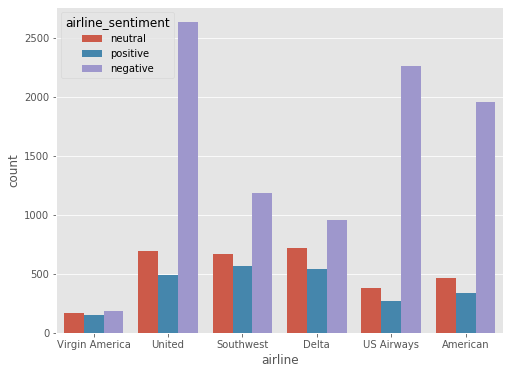

In [9]:
# plot sentiment distribution for each airline
plt.figure(figsize=(8,6))
sns.countplot(x='airline', hue='airline_sentiment', data=data)
plt.show()

We can see from the overall sentiment:
- The negative sentiment has 62.7% in total, which make sense because people tend to express more on negative feelings
- The sentiment distribution is skewed, which need to be kept in mind in the model evaluation. We could potentially have a 62.7% accuracy by predicting everything negative.

We can see from the airline company sentiment:
- The distribution of sentiment within each airline company is different. Virgin America seems evenly distributed, while others seems to have a larger proportion of negative sentiment.
- We want to remove the airline information in the data for prediction. We do not want an overfitting model that treat the airline company as a negative word.

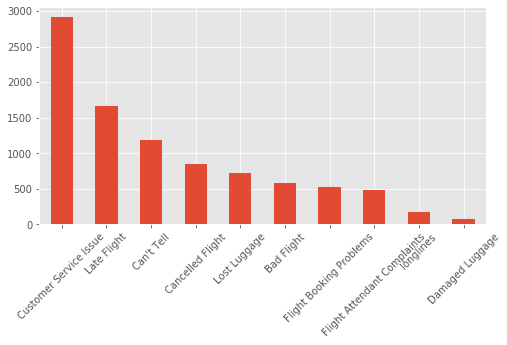

In [10]:
# plot distribution for nagetive reasons
plt.figure(figsize=(8,4))
data['negativereason'].value_counts().plot(kind='bar',rot=45)
plt.show()

We found that most reasons for negative sentiment is due to customer service issue. This information is good to have but little to do with our prediction.

### Data Preprocessing

In [11]:
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.stem.snowball import SnowballStemmer # for Stemming word 
from nltk.tokenize import TweetTokenizer #for tokenize text 
from wordcloud import WordCloud,STOPWORDS

We would like to pre-process the data before feeding into the model. There are many research on pre-processing methods on Twitter data:
- Krouska, A., Troussas, C., & Virvou, M. (2016, July). The effect of preprocessing techniques on Twitter sentiment analysis. In 2016 7th International Conference on Information, Intelligence, Systems & Applications (IISA) (pp. 1-5). IEEE.
- Angiani, G., Ferrari, L., Fontanini, T., Fornacciari, P., Iotti, E., Magliani, F., & Manicardi, S. (2016, September). A Comparison between Preprocessing Techniques for Sentiment Analysis in Twitter. In KDWeb.
- Effrosynidis, D., Symeonidis, S., & Arampatzis, A. (2017, September). A comparison of pre-processing techniques for twitter sentiment analysis. In International Conference on Theory and Practice of Digital Libraries (pp. 394-406). Springer, Cham.

The techniques introduced in above paper are more or less similar to each other. In the paper (Effrosynidis et al., 2017), the authors provided a ranking of the performance of prediction after implementing these techniques. Among them:

High accuracy in all classiﬁers and all datasets:
- Remove Numbers
- Replace Repetitions of Punctuation
- Stemming

High accuracy in most classiﬁers and all datasets:
- Handling Negations
- Lemmatizing
- Other (Replace urls and user mentions)

The repetitions of punctuation could be handled by the language model. We would like to explore if stemming could add value to our prediction. We modify the open sourced code provided by authors.

In [12]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def removeURL(text):
    """ Replaces url address with '' """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',r'',text)
    text = re.sub(r'#([^\s]+)', r'', text)
    return text

def removeAtUser(text):
    """ Replaces "@user" with "" """
    text = re.sub('@[^\s]+','',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def removeSpecialChar(text):
    """ Remove HTML sopecial chars """
    text = re.sub('(&amp;)+',r'and',text)
    text = re.sub('(&lt;)+',r'',text)
    text = re.sub('(&gt;)+',r'',text)
    text = re.sub('(&quot;)+',r'',text)
    return text

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

In [13]:
# pre-precessing
def preprocess(df):
    df = df.copy()
    df['text'] = df['text'].apply(removeUnicode)
    df['text'] = df['text'].apply(removeSpecialChar)
    df['text'] = df['text'].apply(removeURL)
    df['text'] = df['text'].apply(removeAtUser)
    df['text'] = df['text'].apply(removeHashtagInFrontOfWord)
    df['text'] = df['text'].apply(removeEmoticons)
    df['text'] = df['text'].apply(removeNumbers)
    df['text'] = df['text'].apply(replaceContraction)
    return df

def preprocess1(df):
    df = df.copy()
    df = preprocess(df)

    # tokenize
    tokenizer = TweetTokenizer()
    df['text'] = df['text'].apply(tokenizer.tokenize)
    
    # stem
    stemmer = SnowballStemmer('english')
    df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])
    df['text'] = df['text'].apply(lambda x: ' '.join(x))
    return df

In [14]:
df1 = preprocess(df)
df2 = preprocess1(df)

In [15]:
df1.tail()

,text,airline_sentiment
14635,thank you we got on a different flight to Chicago.,positive
14636,leaving over minutes Late Flight. No warnings or communication until we were minutes Late Flight. That is called shitty customer svc,negative
14637,Please bring American Airlines to,neutral
14638,"you have my money, you change my flight, and do not answer your phones! Any other suggestions so I can make my commitment??",negative
14639,we have ppl so we need know how many seats are on the next flight. Plz put us on standby for people on the next flight?,neutral


In [16]:
df2.tail()

,text,airline_sentiment
14635,thank you we got on a differ flight to chicago .,positive
14636,leav over minut late flight . no warn or communic until we were minut late flight . that is call shitti custom svc,negative
14637,pleas bring american airlin to,neutral
14638,"you have my money , you chang my flight , and do not answer your phone ! ani other suggest so i can make my commit ? ?",negative
14639,we have ppl so we need know how mani seat are on the next flight . plz put us on standbi for peopl on the next flight ?,neutral


In [17]:
# adjust columns order and save
def adjust_and_save(df, filename):
    df = df[['airline_sentiment','text']]
    df.columns = ['label','text']
    df.to_csv(filename + ".csv",index=False)
    return df

In [18]:
df1 = adjust_and_save(df1, "Tweet_clean1")
df2 = adjust_and_save(df2, "Tweet_clean2")

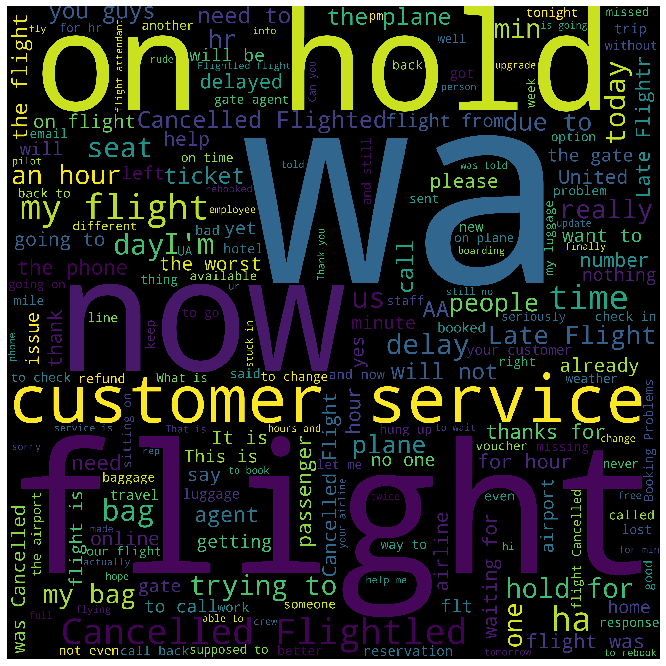

In [19]:
# word cloud for negative
df_wc=df1[df1['label']=='negative']
words_wc = " ".join(df_wc['text'].to_list())
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='black', 
                      width=4000, 
                      height=4000
                     ).generate(words_wc)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

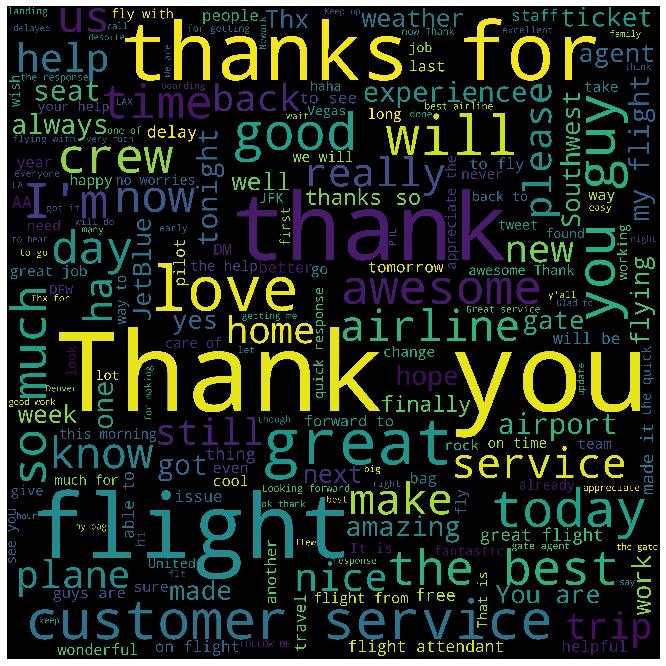

In [20]:
# word cloud for positive
df_wc=df1[df1['label']=='positive']
words_wc = " ".join(df_wc['text'].to_list())
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='black', 
                      width=4000, 
                      height=4000
                     ).generate(words_wc)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see from the word cloud that we generated using comment under negative and positive sentiment:
- negative sentiment mostly caused by bad customer service, filght cancelled or on hold, etc, which is consistent with the negative reason ranking
- people with positive sentiment tend to express their appreciation in a general way as we see a lot of "thank you", "the best", "amazing" in the word cloud

Now we move on to model building

### Model building on df1

In [81]:
df1 = pd.read_csv("Tweet_clean1.csv")
df1.head()

,label,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces and they have little recourse"
4,negative,and it is a really big bad thing about it


In [82]:
# split df into train and validation sets
# we use 80% data for train and 20% data for validation
df_train, df_val = train_test_split(df1, stratify=df1['label'], test_size=0.2, random_state=123)
df_train.head()

,label,text
11563,neutral,"hi! Could you protect me on US just in case? Still on ground with no checked luggage, but still a chance I can make original"
6449,negative,what is up with these delays?! Throw some priority boarding my way and I will forgive you!!
2208,negative,hoping there is a spare a/c for tomorrow! Have a ship to board! The sched aircraft is delayed from previous flts.
6412,negative,"very frustrated with your customer service.Open seats on earlier flight, $ to change. What a rip off!!"
13010,positive,Thank you!!!! I will be there to pick her up on time.


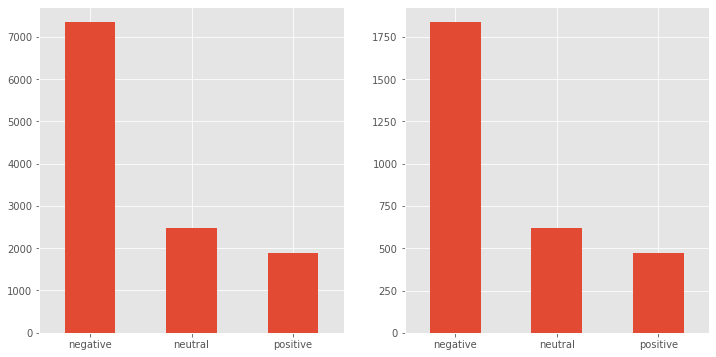

In [83]:
# plot the distribution of sentiments
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_train['label'].value_counts().plot(kind='bar', rot=0, ax=axes[0])
df_val['label'].value_counts().plot(kind='bar', rot=0, ax=axes[1])
plt.show()

In [84]:
print("Training set:")
sentiment_value_count = df_train['label'].value_counts()
for cate in sentiment_value_count.index:
    print(f"Percentage of {cate}: {sentiment_value_count[cate] / sentiment_value_count.sum():.3f}")
    
print("\nValidation set:")
sentiment_value_count = df_val['label'].value_counts()
for cate in sentiment_value_count.index:
    print(f"Percentage of {cate}: {sentiment_value_count[cate] / sentiment_value_count.sum():.3f}")

Training set:
Percentage of negative: 0.627
Percentage of neutral: 0.212
Percentage of positive: 0.161

Validation set:
Percentage of negative: 0.627
Percentage of neutral: 0.212
Percentage of positive: 0.161


We have a equally distributed training and validation set.

In [85]:
# language model
data_lm = TextLMDataBunch.from_df(train_df=df_train, 
                                  valid_df=df_val, 
                                  path = "")

In [86]:
data_lm

TextLMDataBunch;

Train: LabelList (11712 items)
x: LMTextList
xxbos hi ! xxmaj could you protect me on xxup us just in case ? xxmaj still on ground with no checked luggage , but still a chance i can make original,xxbos what is up with these delays ? ! xxmaj throw some priority boarding my way and i will forgive you ! !,xxbos hoping there is a spare a / c for tomorrow ! xxmaj have a ship to board ! xxmaj the sched aircraft is delayed from previous flts .,xxbos very frustrated with your customer service . xxmaj open seats on earlier flight , $ to change . xxmaj what a rip off ! !,xxbos xxmaj thank you xxrep 4 ! i will be there to pick her up on time .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2928 items)
x: LMTextList
xxbos xxmaj another glitch ? ?,xxbos i got a xxunk email claiming to be from xxmaj southwest . i can forward to you if you would like to xxunk .,xxbos xxmaj why does not anyone make a better effort to xxunk customers . xxmaj it should be an easy fix , i just want to 

In [87]:
# classifier model
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = df_train, 
                                      valid_df = df_val, 
                                      vocab=data_lm.train_ds.vocab, 
                                      bs=32)

In [88]:
data_clas.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do not "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
"xxbos xxup ua from xxup ric , xxup ua from xxup ord , and xxup ua from xxup den xxup xxunk xxup delayed for non - weather issues . xxmaj way to go , you re batting . ! xxmaj but no hotels",negative
xxbos xxmaj on my flight today from xxup rsw to xxup grr i was able to xxunk a free xxup sw xxmaj agent to check for me . xxmaj it looks like we are ( finally ) all set .,positive
xxbos xxmaj want to book a multi - city fare . xxmaj have miles for of flights . xxmaj an option to pay for st flight with miles + nd with xxup xxunk xxmaj visa ? xxmaj thanks !,neutral


In [89]:
# download lang model learner AWD-LSTM
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 4.37E-02


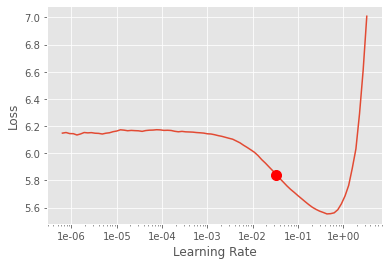

In [90]:
# find learning rate and check suggustion
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [91]:
# train the first layer of the learner
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,5.298589,4.349035,0.213185,00:10
1,4.508135,4.044568,0.244152,00:10
2,4.132876,3.970555,0.251682,00:09
3,3.906380,3.942720,0.255149,00:09
4,3.777910,3.940353,0.254807,00:09


In [92]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.735000,3.920235,0.259970,00:10
1,3.635577,3.878355,0.267366,00:10
2,3.449701,3.876433,0.270521,00:10


In [93]:
# unfreeze and train more
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.392343,3.893120,0.267366,00:13
1,3.312217,3.882842,0.272649,00:13
2,3.104705,3.917599,0.274420,00:13


In [94]:
df_train.iloc[6530]

label                                                                                                      neutral
text      I got it now. Would not let me log on with my email. Thx. Here is hoping for dtw-ase without issue today
Name: 2481, dtype: object

In [95]:
# take a look how the language model perform for predicting the next word
learn.predict("Would not let me log on",n_words=5)

'Would not let me log on online and actions on multiple'

In [96]:
# save the encoder
learn.save_encoder('encoder1')

In [100]:
# train text classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,
                                metrics=[accuracy,Precision(average='weighted'),Recall(average='weighted')])
learn.load_encoder('encoder1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos hi ! xxmaj could you protect me on xxup us just in case ? xxmaj still on ground with no checked luggage , but still a chance i can make original,xxbos what is up with these delays ? ! xxmaj throw some priority boarding my way and i will forgive you ! !,xxbos hoping there is a spare a / c for tomorrow ! xxmaj have a ship to board ! xxmaj the sched aircraft is delayed from previous flts .,xxbos very frustrated with your customer service . xxmaj open seats on earlier flight , $ to change . xxmaj what a rip off ! !,xxbos xxmaj thank you xxrep 4 ! i will be there to pick her up on time .
y: CategoryList
neutral,negative,negative,negative,positive
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos xxmaj another glitch ? ?,xxbos i got a xxunk email claiming to be from xxmaj southwest . i can forward to you if you would like to xxunk .,xxbos xxmaj why does not anyone make a better effort to xxunk custom

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 4.37E-02


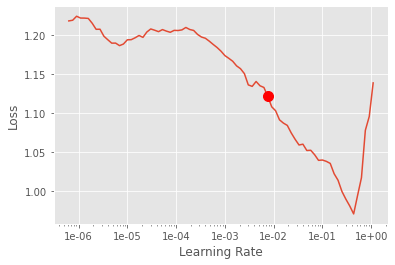

In [101]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [102]:
# gradually unfreeze and fine tune
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.675816,0.597654,0.766735,0.756986,0.766735,00:07
1,0.701707,0.621123,0.761954,0.749164,0.761954,00:07
2,0.614982,0.578771,0.781762,0.780149,0.781762,00:07
3,0.622040,0.557647,0.788934,0.782151,0.788934,00:07
4,0.597185,0.543156,0.796107,0.788375,0.796107,00:07
5,0.610253,0.539141,0.793716,0.786559,0.793716,00:07


In [103]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-4, 5e-3), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.631081,0.544554,0.783470,0.777469,0.783470,00:08
1,0.605609,0.520623,0.797814,0.790976,0.797814,00:08
2,0.479660,0.510949,0.804986,0.797045,0.804986,00:08


In [104]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4, 5e-3), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.513650,0.526350,0.793716,0.787403,0.793716,00:17
1,0.512377,0.483264,0.811817,0.804201,0.811817,00:17
2,0.385621,0.492673,0.811134,0.805622,0.811134,00:17
3,0.267071,0.543367,0.812842,0.806280,0.812842,00:17
4,0.193130,0.548811,0.816940,0.814047,0.816940,00:17


In [105]:
learn.export("classifier1.pkl")

Model 1 has a final accuracy, precision, recall at around 81.4%. From the loss value across training set and validation set, we find the in the end there's a big difference between train and loss, which means high variance.
Let's see how the stemmed data perform.

### Model building on df2

In [106]:
df2 = pd.read_csv("Tweet_clean2.csv")
df2.head()

,label,text
0,neutral,what said .
1,positive,plus you have ad commerci to the experi ... tacki .
2,neutral,i did not today ... must mean i need to take anoth trip !
3,negative,"it is realli aggress to blast obnoxi "" entertain "" in your guest ' face and they have littl recours"
4,negative,and it is a realli big bad thing about it


In [108]:
# split df into train and validation sets
# we use 80% data for train and 20% data for validation
df_train, df_val = train_test_split(df2, stratify=df2['label'], test_size=0.2, random_state=123)
df_train.head()

,label,text
11563,neutral,"hi ! could you protect me on us just in case ? still on ground with no check luggag , but still a chanc i can make origin"
6449,negative,what is up with these delay ? ! throw some prioriti board my way and i will forgiv you ! !
2208,negative,hope there is a spare a / c for tomorrow ! have a ship to board ! the sched aircraft is delay from previous flts .
6412,negative,"veri frustrat with your custom service.open seat on earlier flight , $ to chang . what a rip off ! !"
13010,positive,thank you ! ! ! i will be there to pick her up on time .


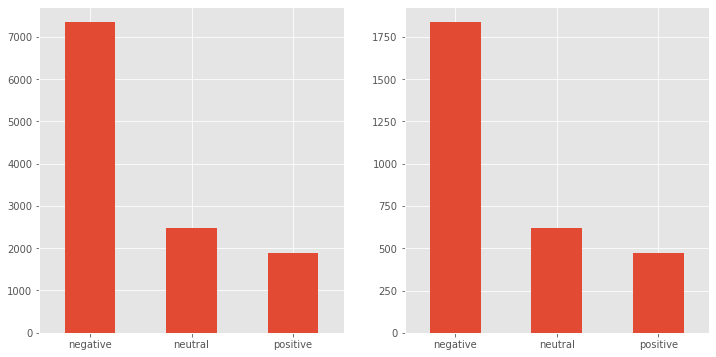

In [109]:
# plot the distribution of sentiments
fig, axes = plt.subplots(1,2,figsize=(12,6))
df_train['label'].value_counts().plot(kind='bar', rot=0, ax=axes[0])
df_val['label'].value_counts().plot(kind='bar', rot=0, ax=axes[1])
plt.show()

In [110]:
print("Training set:")
sentiment_value_count = df_train['label'].value_counts()
for cate in sentiment_value_count.index:
    print(f"Percentage of {cate}: {sentiment_value_count[cate] / sentiment_value_count.sum():.3f}")
    
print("\nValidation set:")
sentiment_value_count = df_val['label'].value_counts()
for cate in sentiment_value_count.index:
    print(f"Percentage of {cate}: {sentiment_value_count[cate] / sentiment_value_count.sum():.3f}")

Training set:
Percentage of negative: 0.627
Percentage of neutral: 0.212
Percentage of positive: 0.161

Validation set:
Percentage of negative: 0.627
Percentage of neutral: 0.212
Percentage of positive: 0.161


We have a equally distributed training and validation set.

In [111]:
# language model
data_lm = TextLMDataBunch.from_df(train_df=df_train, 
                                  valid_df=df_val, 
                                  path = "")

In [112]:
data_lm

TextLMDataBunch;

Train: LabelList (11712 items)
x: LMTextList
xxbos hi ! could you protect me on us just in case ? still on ground with no check luggag , but still a chanc i can make origin,xxbos what is up with these delay ? ! throw some prioriti board my way and i will forgiv you ! !,xxbos hope there is a spare a / c for tomorrow ! have a ship to board ! the sched aircraft is delay from previous flts .,xxbos veri frustrat with your custom xxunk seat on earlier flight , $ to chang . what a rip off ! !,xxbos thank you ! ! ! i will be there to pick her up on time .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (2928 items)
x: LMTextList
xxbos anoth glitch ? ?,xxbos i got a xxunk email claim to be from southwest . i can forward to you if you would like to investig .,xxbos whi doe not anyon make a better effort to xxunk custom . it should be an easi fix , i just want to travel aa .,xxbos thank for the quick respons ! finger cross the plane get here then,xxbos is servic to xxunk be perma

In [113]:
# classifier model
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = df_train, 
                                      valid_df = df_val, 
                                      vocab=data_lm.train_ds.vocab, 
                                      bs=32)
# data_clas.save('data_clas_export.pkl')
# data_clas = load_data('./','data_clas_export.pkl', bs=32)

In [114]:
data_clas.show_batch()

text,target
"xxbos i had to travel to savannah , xxunk , onc again , on an airlin i do not "" luv "" . when r u go to fli me to savannah ? pl xxrep 4 e as ! ! !",neutral
xxbos my hubbi has a hr layov in dfw fm the cxl would flt . pls help get him home sooner if you can ! ani room on s / by bwi or phl today ?,neutral
xxbos aww thank aa .. dfw was on gma up here this am .. so i understand .. btw a . a is my airlin when i m abl to trv .. love you guy .,positive
xxbos i got an email from cust . care for an issu i had offer me a voucher . how do i claim that ? i email back but got no repli . dm me,neutral
"xxbos unit club team is a + and got me a seat late flightr . still , not sure whi a last min ual cancel flightlat cost me $ yet overbook folk get $ ?",negative


In [115]:
# download lang model learner AWD-LSTM
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 6.31E-02


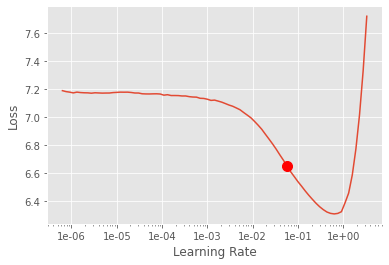

In [116]:
# find learning rate and check suggustion
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [117]:
# train the first layer of the learner
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,6.132879,4.909240,0.173815,00:08
1,5.066235,4.441423,0.217222,00:08
2,4.582143,4.328816,0.225429,00:08
3,4.317523,4.291276,0.228915,00:08
4,4.170200,4.284119,0.228846,00:08


In [118]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,4.096830,4.240905,0.233791,00:08
1,4.002662,4.187098,0.239904,00:08
2,3.830417,4.182337,0.241192,00:08


In [119]:
# unfreeze and train more
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.770433,4.190599,0.239320,00:11
1,3.686366,4.162890,0.245347,00:11
2,3.495664,4.194276,0.245948,00:11


In [120]:
df_train.iloc[6530]

label                                                                                                     neutral
text     i got it now . would not let me log on with my email . thx . here is hope for dtw-ase without issu today
Name: 2481, dtype: object

In [125]:
# take a look how the language model perform for predicting the next word
learn.predict("Would not let me log on",n_words=5)

'Would not let me log on a messag so mani time'

In [123]:
# save the encoder
learn.save_encoder('encoder2')

In [126]:
# train text classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,
                                metrics=[accuracy,Precision(average='weighted'),Recall(average='weighted')])
learn.load_encoder('encoder2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos hi ! could you protect me on us just in case ? still on ground with no check luggag , but still a chanc i can make origin,xxbos what is up with these delay ? ! throw some prioriti board my way and i will forgiv you ! !,xxbos hope there is a spare a / c for tomorrow ! have a ship to board ! the sched aircraft is delay from previous flts .,xxbos veri frustrat with your custom xxunk seat on earlier flight , $ to chang . what a rip off ! !,xxbos thank you ! ! ! i will be there to pick her up on time .
y: CategoryList
neutral,negative,negative,negative,positive
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos anoth glitch ? ?,xxbos i got a xxunk email claim to be from southwest . i can forward to you if you would like to investig .,xxbos whi doe not anyon make a better effort to xxunk custom . it should be an easi fix , i just want to travel aa .,xxbos thank for the quick respons ! finger cross the

epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 6.31E-02


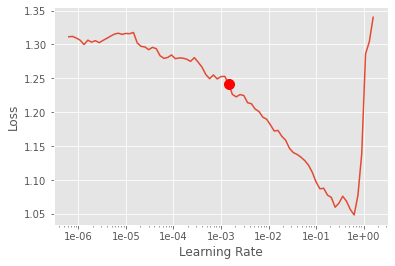

In [127]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [128]:
# gradually unfreeze and fine tune
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.910620,0.738197,0.739413,0.742271,0.739413,00:07
1,0.700884,0.597912,0.764003,0.753461,0.764003,00:07
2,0.713096,0.583690,0.766393,0.762755,0.766393,00:07
3,0.622387,0.571863,0.772199,0.762240,0.772200,00:07
4,0.640343,0.557102,0.777322,0.773415,0.777322,00:07
5,0.597898,0.545867,0.782104,0.774090,0.782104,00:07


In [129]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-4, 1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.617194,0.557180,0.787227,0.778318,0.787227,00:08
1,0.607154,0.541818,0.788593,0.781821,0.788593,00:08
2,0.589752,0.532654,0.795765,0.789522,0.795765,00:08
3,0.519369,0.524633,0.802254,0.794437,0.802254,00:08


In [130]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-4, 1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.536048,0.526770,0.805328,0.798724,0.805328,00:16
1,0.529190,0.516588,0.805669,0.802232,0.805669,00:16
2,0.471670,0.496184,0.820014,0.814515,0.820014,00:16
3,0.376193,0.503988,0.824795,0.818408,0.824795,00:16
4,0.306085,0.525549,0.828210,0.821863,0.828210,00:16
5,0.276631,0.523804,0.827869,0.822309,0.827869,00:16


In [131]:
learn.export("classifier2.pkl")

After our fine tuning, while the language model accuracy is not as good as model 1, it seems that the stemmed version is slightly better in sentiment analysis. It has a 82.8% accuracy. So we analyze the result using the second classifier.

## Result

In [18]:
learn = load_learner(path="./",file="classifier2.pkl")

In [19]:
df_res = df_val.copy()
df_res['pred'] = df_res['text'].apply(lambda row:str(learn.predict(row)[0].obj))

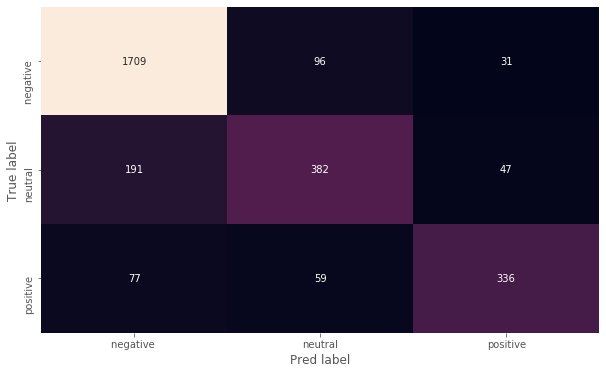

In [20]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(df_res['label'], df_res['pred']),cbar=False,annot=True,fmt='d',
           xticklabels=['negative ','neutral','positive'], yticklabels=['negative ','neutral','positive'],)
plt.xlabel("Pred label")
plt.ylabel("True label")
plt.show()

In [21]:
# check wrong prediction for negative
df_wrong = df_res.loc[(df_res['label']!=df_res['pred']) & (df_res['label']=='negative')] 
df_wrong = df_wrong[['label','pred','text']]
df_wrong.head(10)

,label,pred,text
3155,negative,neutral,"just curious , when are you go to to final learn ?"
13748,negative,positive,"thank , she did her best . stay the night in dalla , new trial to detroit via atlanta tomorrow , assum no cancel flightlat ."
6495,negative,neutral,ani plan to make the southwest app for android not crappi ?
749,negative,neutral,plus what about food ? and taxi ?
14538,negative,neutral,"cool , a can respons . nah , i think i will keep tweet at everyon who mention aa on twitter . you could dm me , though ."
14486,negative,positive,"first the pilot , then the cater ..."
3631,negative,neutral,pleas stall flight out of ord . i have to get to sna tonight .
1379,negative,neutral,is flight go to sit on the tarmac forev ? ? ?
7556,negative,neutral,it is sunni and gorgeous in ny actual . what is the real reason ?
6384,negative,neutral,engadget theverg wire reddit


In [30]:
df.iloc[3155]['text']

'@united just curious, when are you going to to finally learn #customerservice ?'

For negative sentiment, most wrong labels falls into neutral category. There are some kind of tweets, like sarcasm or implied negativity, that the model fails to classify correctly. Overall it did well in this part.

In [26]:
# check wrong prediction for neutral
df_wrong = df_res.loc[(df_res['label']!=df_res['pred']) & (df_res['label']=='neutral')] 
df_wrong = df_wrong[['label','pred','text']]
df_wrong.head(10)

,label,pred,text
4154,neutral,negative,"the guidelin say xx , my bag is x . x . , so it is a bit taller than the guidelin . is that gonna be a problem ?"
2658,neutral,negative,i am go to a servic desk now to see what the option are .
5855,neutral,positive,iphon app add passbook support
888,neutral,negative,"to be clear on my luggag comment , i am referenc the photo attach . flight to jac"
2810,neutral,positive,"blood servic , make your appt . today !"
4182,neutral,negative,"sorri , wrong link for the bag that the one i meant"
9025,neutral,positive,""" airport snow remov method keep up the good work folk , this is where cessna is becom ' s !"
7585,neutral,positive,whatev your lil heart desir !
4650,neutral,positive,thank ! !
7730,neutral,positive,yes parti is over


In [31]:
df.iloc[4650]['text']

'@SouthwestAir thanks!!'

The model did well in this part as well. Sometime it's even hard for human to tell if the tweet is neutral or not. For example, for tweet #4650 above, a human expert is also likely to classify it into positive.

In [22]:
# check wrong prediction for positive
df_wrong = df_res.loc[(df_res['label']!=df_res['pred']) & (df_res['label']=='positive')] 
df_wrong = df_wrong[['label','pred','text']]
df_wrong.head(10)

,label,pred,text
5873,positive,neutral,me and are best friend becaus of ani chanc we could get ticket to ?
12726,positive,negative,"still think , those pjs may have me sold we would to have you on board with us ! here i come"
8628,positive,negative,is the greatest airlin ever
3558,positive,neutral,did i win
2415,positive,negative,they final gave in a let him on . after they threaten to send him back to vega on coach . thnx .
1736,positive,neutral,"thx , just dm would . conf mqxc and mpwnc . ani help appreci"
3408,positive,neutral,yes ! d ( y ) from on instagram
8550,positive,neutral,i would go to las vega . it is gorgeous and i go there everi year and i fli with you guy vega is gorgeous and so much to do there .
8060,positive,negative,i cannot wait to hear back from you regard the internship opportun !
477,positive,negative,wifi and better seat .


In [33]:
df.iloc[8628]['text']

'@JetBlue is the greatest airline ever 💕✈️💺 #TrueBluePoints #jetbluemember'

In [40]:
all_words = " ".join(df_train['text'].to_list())
len(re.findall(r"(greatest)+", all_words))

2

The model does not perform well in this part. Most mistake was made by wrong classify the positive sentiment into negative ones. For example the above tweet (#8628) should have been easily classified as positive, however the model failed. It turns out that the word greatest only appear in the training set twice and the model could be improved if have more data on positive tweets.

### Conclusion

In this project we build a model for Tweeter sentiment data classification. We noticed that the data in unbalanced with higher proportion on negative tweets and different distribution on different airline companies. We then preprocessed our data in tn two ways, one involves common approach like remove url, @, #, etc, and the other added word stemming on top of the first one. We then use ULMFiT model to train both data and found that the data with stemming works slightly better with 82.8% accuracy. Finally we examine the prediction result find the model in general works well and could have some improvement on the positive tweets.

Below are some approaches that we could do to further improve the model:
- Bring in more data, especially on the positive class.
- Bring more information into the model. Currently we removed the information like emotions, which could be useful if the language model could learn and make prediction on these info.
- Improve fine tuning process. So far we choose both model to have dropout rate of 0.5 and similar fine tune process. We could explore different settings and have a better model.